In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
fol = '/home/alessio/m-dynamicshere/results'
#fol = '/home/alessio/Desktop/a-3dScanSashaSupport/n-Propagation/results'
subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir != os.path.join(fol,'.ipynb_checkpoints')])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> 1_2_nac_0001
1 -> b-pulseAlongX_0000
2 -> b-pulseAlongX_0001
3 -> c-pulsealongY_0000
4 -> c-pulsealongY_0001
5 -> f-doublePulseXandZ_0000
6 -> f-doublePulseXandZ_0001
7 -> normal_one_0001
8 -> w-from6withouspulse_0000
9 -> x-from5withouspulse_0000
10 -> y-from4withouspulse_0000
11 -> z-benchmark_0000
12 -> z-from3withouspulse_0000



In [4]:
interactive = True
subfolder = subfolders[2]
#subfolder = subfolders[0]

In [11]:
a = os.path.join(fol,subfolder)

filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
# dictio.keys()
zeroWF = qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')
vmaxV = abs2(zeroWF).max()
phiL,gamL,theL,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
filesN = len(filesList)
allwf = np.empty((filesN,phiL,gamL,theL,nstates),dtype=complex)
alltime = np.empty((filesN))
lastV = len(filesList)-1

for i,fn in enumerate(filesList):
    fnn = os.path.join(a,fn)
    allwf[i] = qp.retrieve_hdf5_data(fnn,'WF')
    alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]

outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['count','steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse']
result = pd.concat([data, dataP], axis=1);

phisT, gamsT, thesT = qp.fromFloatsToLabels(phis, gams, thes)


equi_p = phisT.index('P000-000')
equi_g = gamsT.index('P016-923')
equi_t = thesT.index('P114-804')


# 2D slices

In [12]:
def heatThisP(i,first,second,vmaxV,state,sliced,which,save=None):
    '''
    
    '''
    wf = allwf[i]
    time = alltime[i]
    aaa = np.rad2deg
    save = save or False
    fig = plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
    #fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.title('Time = {:10.5f} fs'.format(time))

    if which == 'phi':
        wf   = wf[sliced,:,:,state]
        plt.ylabel('Gamma')
        plt.xlabel('Theta')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),aaa(first[0]),aaa(first[-1])]
    
    elif which == 'gam':
        wf   = wf[:,sliced,:,state]
        plt.ylabel('Phi')
        plt.xlabel('Theta')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
        
    elif which == 'the':
        wf   = wf[:,:,sliced,state]
        plt.ylabel('Phi')
        plt.xlabel('Gamma')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
    

    
    # this is to get a nice colorbar on the side
    ax = plt.gca()

    im = ax.imshow(qp.abs2(wf), extent=ext, cmap='hot', vmax=vmaxV)
    #im = ax.imshow(qp.abs2(wf), cmap='PuBu_r', vmax=0.4)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    
    if save:
        fig.savefig(os.path.splitext(h5File)[0] + '.png')
        plt.close()

# Phi Slices

In [13]:
def f_tg(frame,state,phi):
    return heatThisP(frame,gams,thes,vmaxV,state,phi,'phi')

interact(f_tg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p));
createimages = False

A Jupyter Widget

# Gamma slices

In [14]:
def f_pt(frame, state, gamma):
    return heatThisP(frame,phis,thes,vmaxV,state,gamma,'gam')

interact(f_pt, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g));

A Jupyter Widget

# Theta slices

In [9]:
def f_pg(frame, state, theta):
    return heatThisP(frame,phis,gams,vmaxV,state,theta,'the')

interact(f_pg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t));

A Jupyter Widget

# 1d slices DIFFERENT STATES AT DIFFERENT HIGH

In [15]:
nstates

8

In [16]:
%matplotlib notebook
def slice1D(fN, first, second, label, exa):
    fig = plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
    exa = exa*10
    wf = allwf[fN]
    time = alltime[fN]
    initialEne = result['Total'][0]
    initialEne = (np.arange(nstates)*2)+ initialEne
    #plt.ylim(-1,15)
    #plt.ylim(4,10)
    #plt.xlim(0.7,1.1)
    if label == 'phi':
        ys = wf[:,first,second,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][:,first,second,:])
        plt.title('Time = {:10.5f} fs | gamma = {:8.3f} | theta = {:8.3f}'.format(time,gams[first],thes[second]))
        labelsX = phis
        plt.xlabel('Phi')
    if label == 'gam':
        ys = wf[first,:,second,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][first,:,second,:])
        plt.title('Time = {:10.5f} fs | phi = {:8.3f} | theta = {:8.3f}'.format(time,phis[first],thes[second]))
        labelsX = gams
        plt.xlabel('Gamma')
    if label == 'the':
        ys = wf[first,second,:,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][first,second,:,:])
        plt.title('Time = {:10.5f} fs | phi = {:8.3f} | gamma = {:8.3f}'.format(time,phis[first],gams[second]))
        labelsX = thes
        plt.xlabel('Theta')

    thres = 1e-13
    
    # np.imag of "nan" is 0.0
    
    realPart = np.real(ys)*exa
    imagPart = np.imag(ys)*exa
    absPart = abs2(ys)*exa*5
    
    #extien = 1

    #booleans = abs2(ys)<thres

    #extended_bboleans = booleans + np.roll(booleans,-extien) + np.roll(booleans,extien)    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']
    high = [0.2,5,5,5,5,5,5,5]
    #realPart2 = np.where(extended_bboleans,np.nan,realPart) 
    #imagPart2 = np.where(extended_bboleans,np.nan,imagPart) 
    #absPart2 = np.where(extended_bboleans,np.nan,absPart) 
    for iii in range(nstates):
        realPart2 = realPart[:,iii] + high[iii]
        imagPart2 = imagPart[:,iii] + high[iii]
        absPart2 = absPart[:,iii] + high[iii]
        poten_cut2 = poten_cut[:,iii]
        plt.plot(labelsX, realPart2, linewidth=1,ls='--')
        plt.plot(labelsX, imagPart2, linewidth=1,ls='--')
        plt.plot(labelsX, absPart2, linewidth=2,ls='-', color=colors[iii])
        plt.plot(labelsX, poten_cut2, linewidth=3,ls='-',color=colors[iii])

In [17]:
def fthe(file_number,phi,gamma,exa):
    return slice1D(file_number, phi, gamma, 'the', exa)

interact(fthe, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=0), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=22), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=22), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

A Jupyter Widget

## 1D Phi

In [12]:
def fphi(file_number,gamma, theta,exa):
    return slice1D(file_number, gamma, theta, 'phi', exa)

interact(fphi, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

A Jupyter Widget

## 1D Gamma

In [13]:
def fgam(file_number,phi,theta,exa):
    return slice1D(file_number, phi, theta, 'gam', exa)

interact(fgam, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

A Jupyter Widget

## 1D Theta

In [14]:
def fthe(file_number,phi,gamma,exa):
    return slice1D(file_number, phi, gamma, 'the', exa)

interact(fthe, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

A Jupyter Widget

# Population and Energies

In [15]:
result = pd.concat([data, dataP], axis=1)
result

,count,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2,3,4,5,6,7,8
0,0,0,0.000000,3.219647e-15,0.094606,0.152973,0.247577,0.000000e+00,-3.094663e-07,0.0,2.263836e-07,0.0000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,200,0.020020,1.649079e-08,0.094608,0.152971,0.247577,1.216468e-07,-3.345464e-07,0.0,2.431265e-07,0.0200,1.000000,2.414330e-14,1.900080e-09,6.475190e-11,8.754760e-12,3.048550e-10,7.695300e-10,3.775260e-09
2,2,400,0.040040,6.596245e-08,0.094615,0.152963,0.247577,2.670600e-07,-3.472084e-07,0.0,2.600129e-07,0.0400,1.000000,1.003410e-13,7.458450e-09,2.531280e-10,3.408600e-11,1.189340e-09,2.984570e-09,1.470350e-08
3,3,600,0.060060,1.484128e-07,0.094628,0.152951,0.247577,4.359679e-07,-3.463204e-07,0.0,2.770018e-07,0.0601,1.000000,2.278830e-13,1.626380e-08,5.482000e-10,7.331290e-11,2.567370e-09,6.382120e-09,3.165520e-08
4,4,800,0.080079,2.638384e-07,0.094644,0.152934,0.247577,6.280824e-07,-3.312494e-07,0.0,2.940497e-07,0.0801,0.999999,3.971350e-13,2.767710e-08,9.240130e-10,1.223440e-10,4.306800e-09,1.057380e-08,5.290290e-08
5,5,1000,0.100099,4.122343e-07,0.094666,0.152912,0.247576,8.430990e-07,-3.019113e-07,0.0,3.111111e-07,0.1001,0.999999,5.904650e-13,4.089430e-08,1.348640e-09,1.761830e-10,6.245450e-09,1.509140e-08,7.633030e-08
6,6,1200,0.120119,5.935940e-07,0.094693,0.152885,0.247576,1.080697e-06,-2.588021e-07,0.0,3.281381e-07,0.1201,0.999999,7.849650e-13,5.502410e-08,1.787830e-09,2.295380e-10,8.209530e-09,1.945510e-08,9.968270e-08
7,7,1400,0.140139,8.079098e-07,0.094725,0.152853,0.247576,1.340541e-06,-2.030052e-07,0.0,3.450806e-07,0.1401,0.999998,9.566180e-13,6.916860e-08,2.208810e-09,2.774440e-10,1.003260e-08,2.324550e-08,1.208150e-07
8,8,1600,0.160159,1.055173e-06,0.094762,0.152816,0.247576,1.622279e-06,-1.361769e-07,0.0,3.618864e-07,0.1602,0.999998,1.085250e-12,8.249980e-08,2.583630e-09,3.158120e-10,1.157290e-08,2.613540e-08,1.379410e-07
9,9,1800,0.180179,1.335372e-06,0.094803,0.152775,0.247575,1.925543e-06,-6.050605e-08,0.0,3.785010e-07,0.1802,0.999997,1.159450e-12,9.432190e-08,2.891750e-09,3.418510e-10,1.272600e-08,2.793310e-08,1.497820e-07


<IPython.core.display.Javascript object>


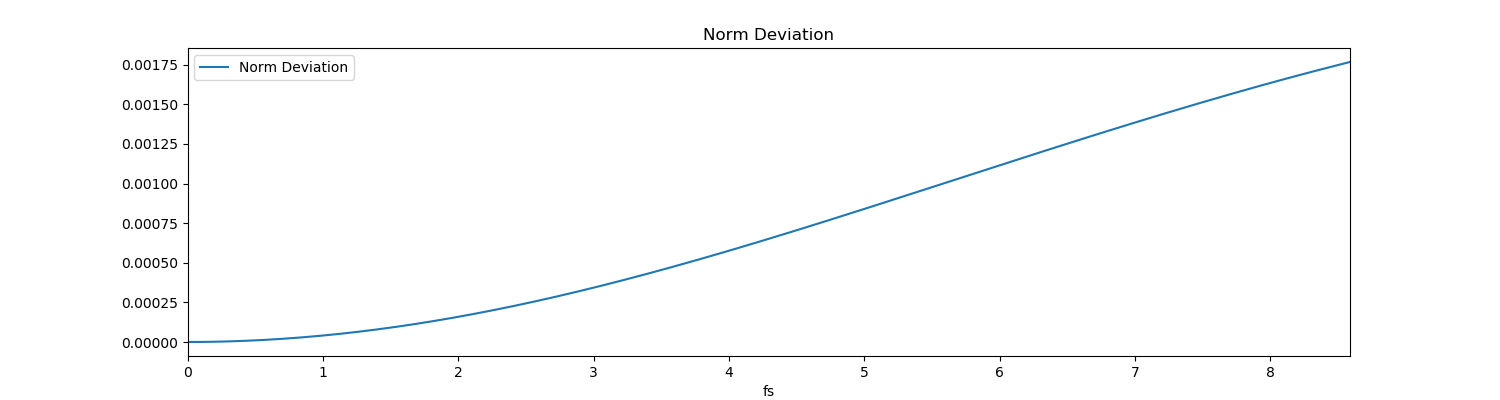

<IPython.core.display.Javascript object>


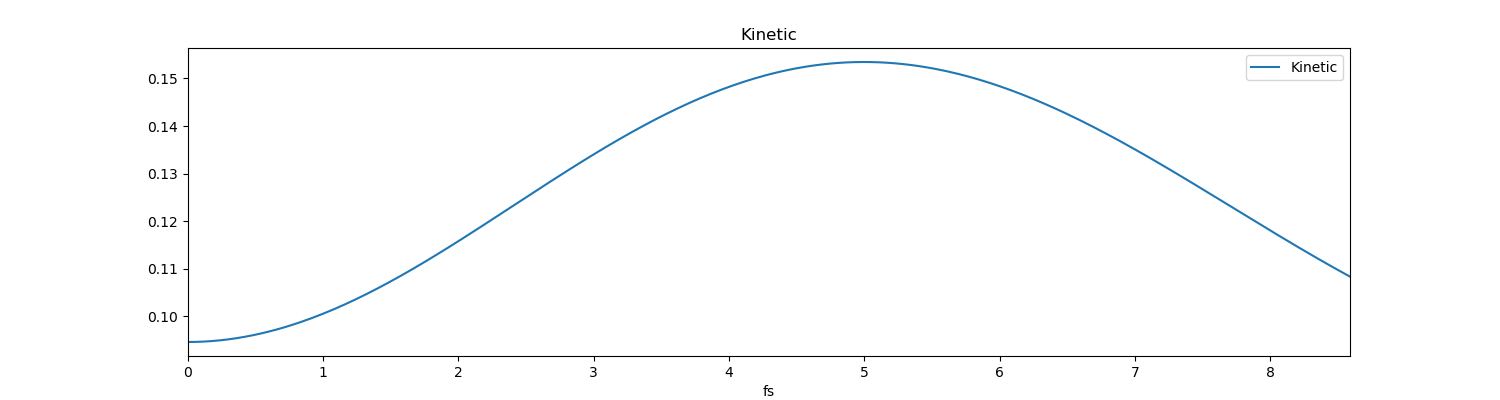

<IPython.core.display.Javascript object>


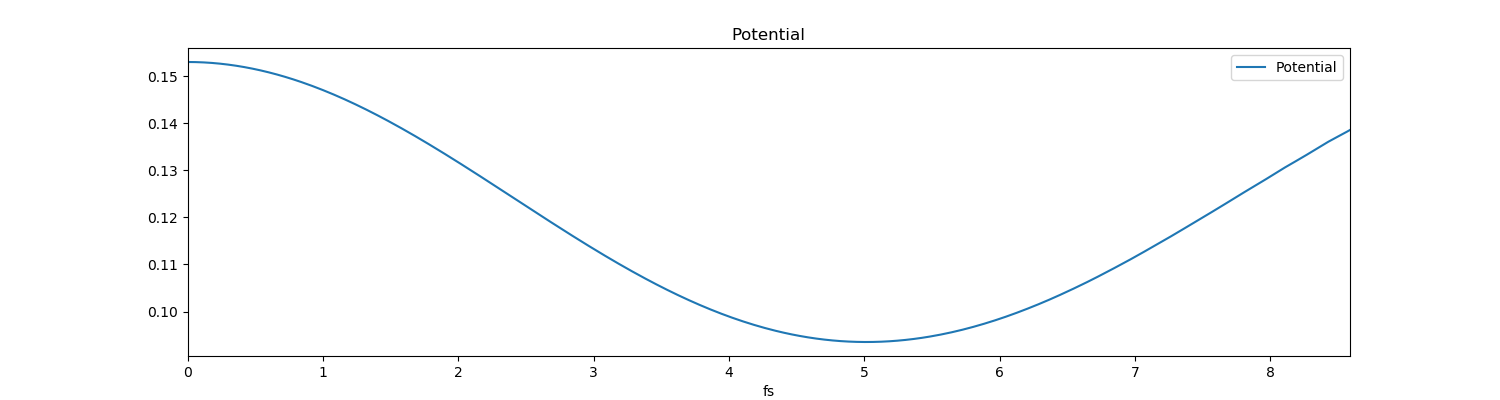

<IPython.core.display.Javascript object>


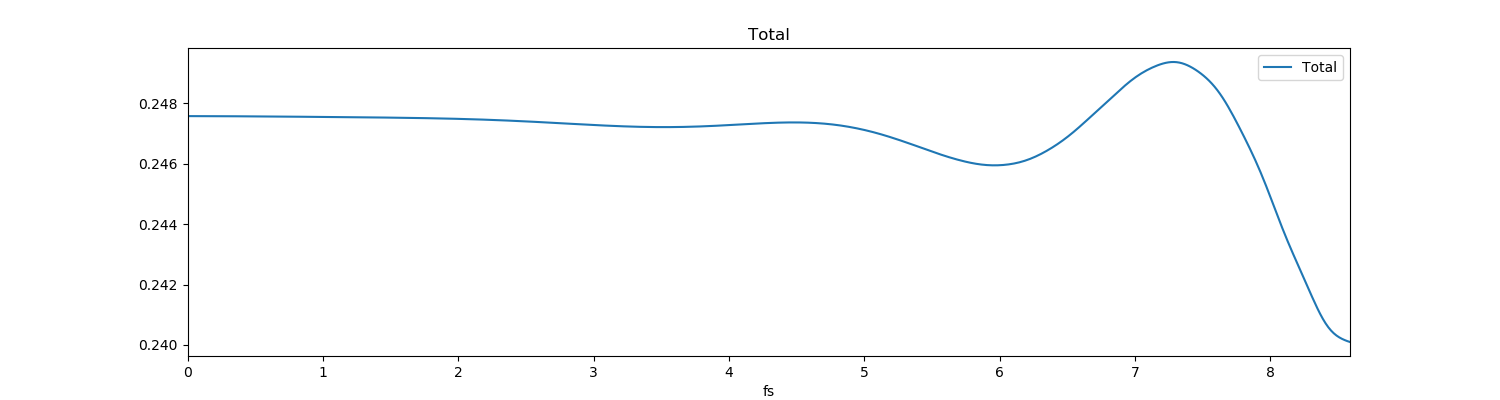

In [16]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4))
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));
data.plot(title = 'Total', x='fs', y = 'Total', figsize=(15,4));

<IPython.core.display.Javascript object>


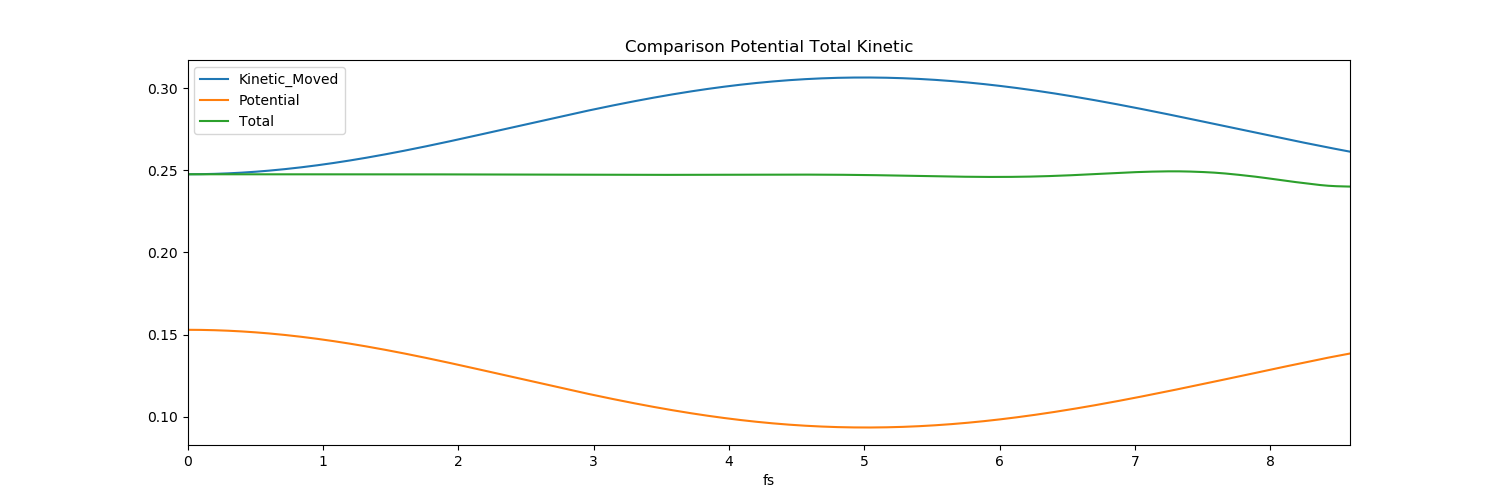

In [17]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

<IPython.core.display.Javascript object>


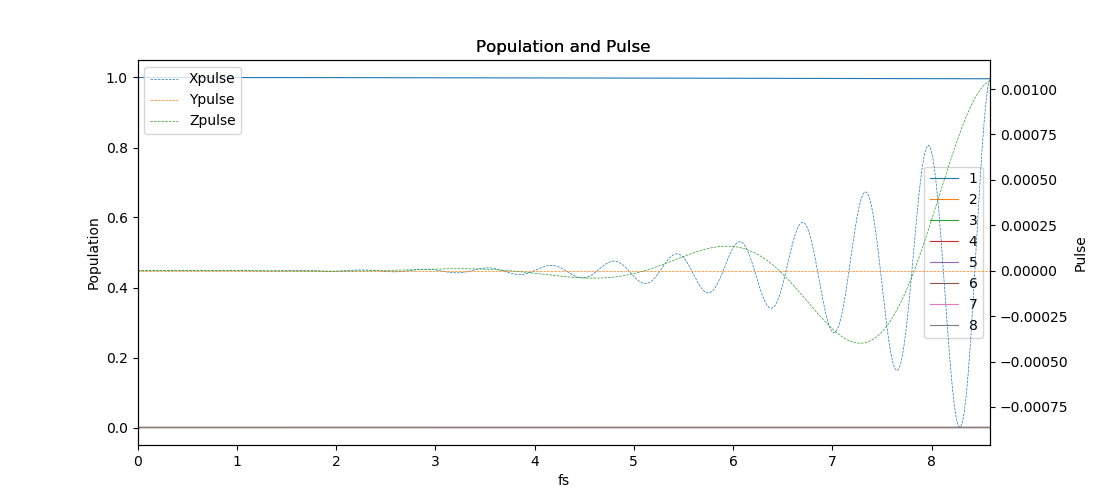

In [18]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')
popul = np.arange(nstates)+1
result.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');

In [19]:
# fig = plt.figure(figsize=(13,8))

# ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6],xticklabels=[])
# ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])

# ax1.set_ylabel('Population')

# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']

# x1 = result['fs'][:200]
# for i in np.arange(nstates):
#     y1 = result[i+1][:200]
#     col = colors[i]
#     laby = r'$S_{{{}}}$'.format(i)
#     ax1.plot(x1,y1,color=col, label=laby)

# ax2.set_ylabel('Pulse (eV)')

# y2 = result['Xpulse'][:200]
# ax2.set_xlabel('fs')
# ax2.plot(x1,y2)
# ax1.legend()

# plt.savefig('vediamo.svg')

# plt.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
# result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');

In [20]:
result

,count,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2,3,4,5,6,7,8
0,0,0,0.000000,3.219647e-15,0.094606,0.152973,0.247577,0.000000e+00,-3.094663e-07,0.0,2.263836e-07,0.0000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,200,0.020020,1.649079e-08,0.094608,0.152971,0.247577,1.216468e-07,-3.345464e-07,0.0,2.431265e-07,0.0200,1.000000,2.414330e-14,1.900080e-09,6.475190e-11,8.754760e-12,3.048550e-10,7.695300e-10,3.775260e-09
2,2,400,0.040040,6.596245e-08,0.094615,0.152963,0.247577,2.670600e-07,-3.472084e-07,0.0,2.600129e-07,0.0400,1.000000,1.003410e-13,7.458450e-09,2.531280e-10,3.408600e-11,1.189340e-09,2.984570e-09,1.470350e-08
3,3,600,0.060060,1.484128e-07,0.094628,0.152951,0.247577,4.359679e-07,-3.463204e-07,0.0,2.770018e-07,0.0601,1.000000,2.278830e-13,1.626380e-08,5.482000e-10,7.331290e-11,2.567370e-09,6.382120e-09,3.165520e-08
4,4,800,0.080079,2.638384e-07,0.094644,0.152934,0.247577,6.280824e-07,-3.312494e-07,0.0,2.940497e-07,0.0801,0.999999,3.971350e-13,2.767710e-08,9.240130e-10,1.223440e-10,4.306800e-09,1.057380e-08,5.290290e-08
5,5,1000,0.100099,4.122343e-07,0.094666,0.152912,0.247576,8.430990e-07,-3.019113e-07,0.0,3.111111e-07,0.1001,0.999999,5.904650e-13,4.089430e-08,1.348640e-09,1.761830e-10,6.245450e-09,1.509140e-08,7.633030e-08
6,6,1200,0.120119,5.935940e-07,0.094693,0.152885,0.247576,1.080697e-06,-2.588021e-07,0.0,3.281381e-07,0.1201,0.999999,7.849650e-13,5.502410e-08,1.787830e-09,2.295380e-10,8.209530e-09,1.945510e-08,9.968270e-08
7,7,1400,0.140139,8.079098e-07,0.094725,0.152853,0.247576,1.340541e-06,-2.030052e-07,0.0,3.450806e-07,0.1401,0.999998,9.566180e-13,6.916860e-08,2.208810e-09,2.774440e-10,1.003260e-08,2.324550e-08,1.208150e-07
8,8,1600,0.160159,1.055173e-06,0.094762,0.152816,0.247576,1.622279e-06,-1.361769e-07,0.0,3.618864e-07,0.1602,0.999998,1.085250e-12,8.249980e-08,2.583630e-09,3.158120e-10,1.157290e-08,2.613540e-08,1.379410e-07
9,9,1800,0.180179,1.335372e-06,0.094803,0.152775,0.247575,1.925543e-06,-6.050605e-08,0.0,3.785010e-07,0.1802,0.999997,1.159450e-12,9.432190e-08,2.891750e-09,3.418510e-10,1.272600e-08,2.793310e-08,1.497820e-07


## Expected values

In [21]:
def expected(fN):
    wf = allwf[fN]
    time = alltime[fN]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    for i in range(nstates):
        wfState = wf[:,:,:,i]
        popu = np.linalg.norm(wfState) # this is norm, the real popu is this squared
        if popu == 0:
            print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi: - \n  Theta: - \n  Gamma: -'.format(i, popu**2))
        else:
            wfA = abs2(wfState/popu)
            # We need to sun and then sum again. From 3d to 1d.
            phiAvg = np.sum(np.sum(wfA,axis=2),axis=1)
            gamAvg = np.sum(np.sum(wfA,axis=2),axis=0)
            theAvg = np.sum(np.sum(wfA,axis=1),axis=0)
            phiA = sum([ phis[i] * phiAvg[i] for i in range(phiAvg.size) ])
            gamA = sum([ gams[i] * gamAvg[i] for i in range(gamAvg.size) ])
            theA = sum([ thes[i] * theAvg[i] for i in range(theAvg.size) ])
            print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi:   {:10.3f} \n  Theta: {:10.3f} \n  Gamma: {:10.3f}'.format(i, popu**2, phiA, theA, gamA))

def fexp(frame):
    return expected(frame)

if interactive:
    interact(fexp, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    fexp(0)
    print('Last Step:')
    fexp(lastV)

A Jupyter Widget

## Look at side of cell

In [22]:
def side(fN):
    wf = allwf[fN]
    time = alltime[fN]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    for i in range(nstates):
        wfAB = qp.abs2(wf[:,:,:,i])
        print('State {}:'.format(i))
        print('Phi -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[-1,:,:]),np.sum(wfAB[0,:,:])))
        print('Gam -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[:,-1,:]),np.sum(wfAB[:,0,:])))
        print('The -> {:5.2e} {:5.2e}\n'.format(np.sum(wfAB[:,:,-1]),np.sum(wfAB[:,:,0])))


def side_f(frame):
    return side(frame)

if interactive:
    interact(side_f, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    side_f(0)
    print('Last Step:')
    side_f(lastV)   

A Jupyter Widget